In [8]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from dotenv import load_dotenv


In [9]:
load_dotenv()
os.environ.get('TRAINING_DIRECTORY')


'C:/Users/nikla/Documents/Semester6/data/cucumber-dataset-compressed-small/normal-light'

In [10]:
# Set the path to the folders containing the images
# train_dir = './training_data/'
train_dir = os.environ.get('TRAINING_DIRECTORY')

# Define the image size
img_height = 1024
img_width = 1024

# Define the batch size
batch_size = 32


In [11]:
# Create a training dataset from the images in the training folder
(train_ds, validation_ds) = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset="both",
    seed=123,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 40 files belonging to 2 classes.
Using 32 files for training.
Using 8 files for validation.


['mini-healthy', 'mini-infected']


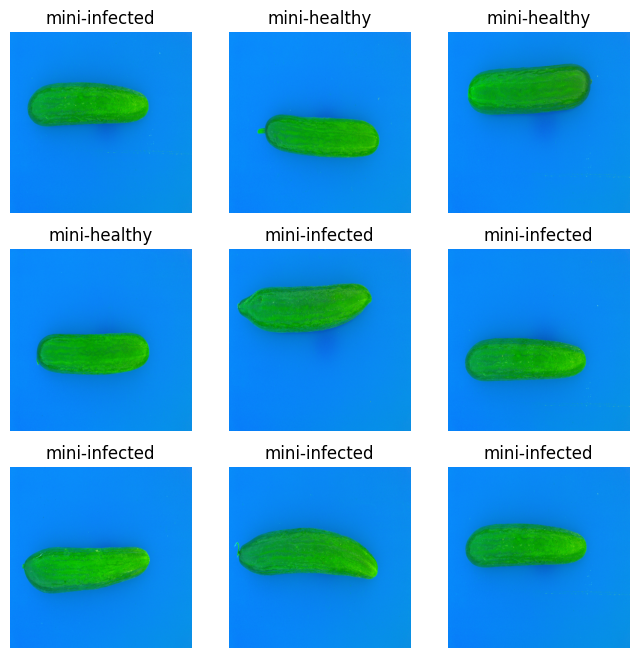

In [12]:
classes = train_ds.class_names
print(classes)

# Plot some images with their labels
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(classes[labels[i]])
        plt.axis('off')


In [13]:
(img_batch, label_batch) = (train_ds.as_numpy_iterator().next())


In [14]:
img_batch = img_batch.astype('uint8')
print(img_batch[0].shape)
print(label_batch.shape)
print(img_batch[0])


(1024, 1024, 3)
(32,)
[[[  9 131 250]
  [  8 136 253]
  [  9 133 254]
  ...
  [ 18 127 235]
  [ 15 135 238]
  [  6 143 245]]

 [[  9 133 251]
  [  9 131 250]
  [ 12 131 254]
  ...
  [ 19 131 236]
  [  9 143 242]
  [ 14 146 238]]

 [[  8 133 251]
  [  8 130 249]
  [ 10 134 251]
  ...
  [ 21 129 241]
  [ 15 135 248]
  [ 38 139 243]]

 ...

 [[ 12 135 249]
  [  6 138 251]
  [ 10 129 253]
  ...
  [  5 148 229]
  [  7 140 241]
  [  7 141 227]]

 [[  7 133 243]
  [  6 136 247]
  [  7 127 251]
  ...
  [  8 140 230]
  [  6 143 229]
  [  7 140 219]]

 [[  4 128 245]
  [  3 131 248]
  [  6 119 252]
  ...
  [ 14 138 234]
  [  6 143 227]
  [  7 138 229]]]
